Motivation: Alex-net level accuracy but with very less number of params and lightweight model, typically around 4.8 mb (with compression < 0.5 mb)

Used Firemodule which follows squeeze -> expand formula across the image channels|

In [2]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import accuracy_score
from torchsummary import summary

In [3]:
BATCH_SIZE = 256
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
NUM_WORKERS = 4
best_val_loss = 1e9

In [4]:
train_dataset = datasets.CIFAR10(root='../data', 
                                 train=True, 
                                 transform=transforms.ToTensor(),
                                 download=True)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          num_workers=NUM_WORKERS,
                          drop_last=True,
                          shuffle=True)

test_dataset = datasets.CIFAR10(root='../data', 
                                train=False,
                                transform=transforms.ToTensor())

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS,
                         drop_last=False,
                         shuffle=False)

# Checking the dataset
all_train_labels = []
all_test_labels = []

for images, labels in train_loader:  
    all_train_labels.append(labels)
all_train_labels = torch.cat(all_train_labels)
    
for images, labels in test_loader:  
    all_test_labels.append(labels)
all_test_labels = torch.cat(all_test_labels)

100%|██████████| 170M/170M [00:18<00:00, 9.29MB/s] 


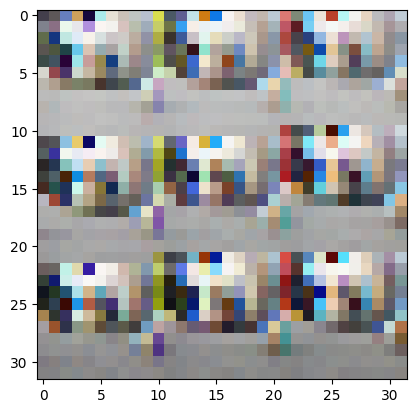

In [5]:
img = next(iter(train_loader))
plt.imshow(img[0][1].reshape(32,32,3))

In [6]:
majority_prediction = torch.argmax(torch.bincount(all_test_labels))
baseline_acc = torch.mean((all_test_labels == majority_prediction).float())
print(f'Baseline ACC: {baseline_acc*100:.2f}%')

Baseline ACC: 10.00%


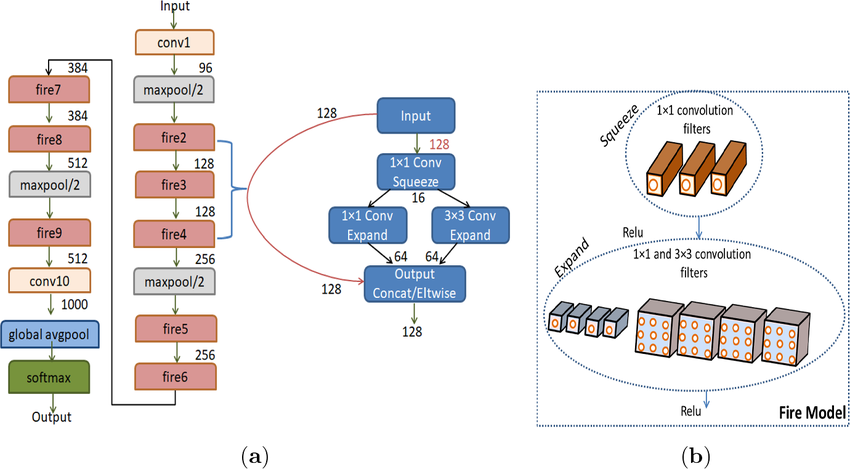

In [18]:
from IPython.display import Image
Image(filename='data/image/Squeezenet.png') 

Here’s the key idea:
**The authors chose expand depths to grow gradually so that the network gains representational power as it gets deeper, but without blowing up parameters.**

Let me guide you with one small question first:

### **Do you notice that in each Fire module:**

* **Expand channels = 4 × squeeze channels**,
* and **squeeze channels slowly increase across the network** (e.g., 16 → 32 → 48 → 64)?

This gives the expand outputs the pattern you’re seeing (64 → 128 → 192 → 256).

Do you see how this “×4 and slowly increasing squeeze” rule explains the pattern? If yes, I’ll show how this choice balances model size vs. accuracy.


---

## **1) They needed accuracy comparable to AlexNet**

AlexNet grows its channels like this:

* 96 → 256 → 384 → 384 → 256

If SqueezeNet kept channels too small, it would lose accuracy.
So the expand layers must eventually reach **AlexNet-like representational capacity**, but **not all at once**.

Hence the gradual scaling.

---

## **2) A smooth growth avoids sudden parameter spikes**

Remember:
**Expand 3×3 params ∝ (input_channels) × (expand_channels)**

If they jumped from 16 to 128 channels suddenly, FLOPs would explode.

By growing smoothly:

* Fire2 expands to 64
* Fire3 expands to 128
* Fire4 expands to 128
* Fire5 expands to 256
  …they keep computation **controlled**.

This linear rise is the sweet spot between:

* too small (bad accuracy)
* too big (too many params)

---

## **3) The ×4 ratio (expand = 4×squeeze) preserves expressivity**

1×1 squeeze reduces channels aggressively,
but if the expand were too small, the network couldn’t recover expressive power.

By choosing:

* **expand = 4 × squeeze**,
  and
* **equal split** between 1×1 expand and 3×3 expand,

each Fire module can:

* mix channels (1×1 expand)
* extract spatial features (3×3 expand)

while still being efficient.

---

## **4) Early layers: keep small for efficiency**

Feature maps early in the network have **large spatial size**, so convolution is expensive.

So early Fire modules use:

* small squeeze (16)
* smaller expand (64)

This keeps compute low.

---

## **5) Later layers: increase channels because spatial resolution shrinks**

After pooling, feature maps get smaller (e.g., from 56×56 to 28×28).

Now they can afford more channels:

* squeeze 48 → expand 192
* squeeze 64 → expand 256

This mirrors the design of many CNNs:
**as spatial dims shrink, channel dims grow.**

---

## **Summary (core idea)**

The sequence **16 → 32 → 48 → 64 squeeze** and **64 →128 →192 →256 expand** is chosen because:

* Starts small to keep early compute low.
* Grows gradually to avoid parameter explosions.
* Matches AlexNet’s representational needs.
* Preserves a balanced squeeze-to-expand ratio.
* Aligns with shrinking spatial dimensions.

---

In [13]:
# Define the Fire Module
class FireModule(torch.nn.Module):
    def __init__(self, in_channels, squeeze_channels, expand1x1_channels, expand3x3_channels):
        super(FireModule, self).__init__()
        self.squeeze = torch.nn.Conv2d(in_channels, squeeze_channels, kernel_size=1)
        self.expand1x1 = torch.nn.Conv2d(squeeze_channels, expand1x1_channels, kernel_size=1)
        self.expand3x3 = torch.nn.Conv2d(squeeze_channels, expand3x3_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.squeeze(x))
        return torch.cat([
            F.relu(self.expand1x1(x)),
            F.relu(self.expand3x3(x))
        ], 1)

class SqueezeNet(torch.nn.Module):
    def __init__(self, num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes

        # Initial convolution layer
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 96, kernel_size=7, stride=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        )

        # Fire modules
        self.features.add_module("fire2", FireModule(96, 16, 64, 64))
        self.features.add_module("fire3", FireModule(128, 16, 64, 64))
        self.features.add_module("fire4", FireModule(128, 32, 128, 128))
        self.features.add_module("maxpool4", torch.nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True))
        self.features.add_module("fire5", FireModule(256, 32, 128, 128))

        # Additional Fire modules as needed
        # ...

        # Adjust the final Fire module to output 512 channels
        self.features.add_module("final_fire", FireModule(256, 64, 256, 256))

        # Final convolution layer
        self.final_conv = torch.nn.Conv2d(512, self.num_classes, kernel_size=1)

        # Dropout and classifier
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(p=0.5),
            self.final_conv,
            torch.nn.ReLU(inplace=True),
            torch.nn.AdaptiveAvgPool2d((1, 1))
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.view(x.size(0), self.num_classes)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
device

'cuda'

In [14]:
model = SqueezeNet(num_classes=10)
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

0.319274 M parameters


In [15]:
summary(m,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 13, 13]          14,208
              ReLU-2           [-1, 96, 13, 13]               0
         MaxPool2d-3             [-1, 96, 6, 6]               0
            Conv2d-4             [-1, 16, 6, 6]           1,552
            Conv2d-5             [-1, 64, 6, 6]           1,088
            Conv2d-6             [-1, 64, 6, 6]           9,280
        FireModule-7            [-1, 128, 6, 6]               0
            Conv2d-8             [-1, 16, 6, 6]           2,064
            Conv2d-9             [-1, 64, 6, 6]           1,088
           Conv2d-10             [-1, 64, 6, 6]           9,280
       FireModule-11            [-1, 128, 6, 6]               0
           Conv2d-12             [-1, 32, 6, 6]           4,128
           Conv2d-13            [-1, 128, 6, 6]           4,224
           Conv2d-14            [-1, 12

In [16]:
for ep in range(NUM_EPOCHS):
    all_pred_labels = []
    trl = 0
    m.train()
    for x_b, y_b in train_loader:
        x_b = x_b.to(device)
        y_b = y_b.to(device)
        logits = m(x_b)
        loss = F.cross_entropy(logits, y_b)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        trl += loss.item()
    
    m.eval()
    with torch.no_grad():
        vdl = 0
        for x_v_b, y_v_b in test_loader:
            x_v_b, y_v_b = x_v_b.to(device), y_v_b.to(device)
            logits = m(x_v_b)
            loss = F.cross_entropy(logits, y_v_b)
            vdl += loss.item()
        print(f'epoch {ep} | train_loss: {trl/len(train_loader):.4f} valid_loss: {vdl/len(test_loader):.4f}')
    
    if vdl < best_val_loss:
        best_val_loss = vdl
        for x_v_b, y_v_b in test_loader:
            x_v_b, y_v_b = x_v_b.to(device), y_v_b.to(device)
            logits = m(x_v_b)
            pred_label = F.softmax(logits,dim=-1).argmax(dim=-1)
            all_pred_labels.extend(list(pred_label.detach().cpu().flatten().numpy()))
        print("Accuracy: ",accuracy_score(all_test_labels.detach().cpu().flatten().numpy(), all_pred_labels))

epoch 0 | train_loss: 2.2642 valid_loss: 2.1636
Accuracy:  0.1356
epoch 1 | train_loss: 2.1130 valid_loss: 2.0697
Accuracy:  0.2244
epoch 2 | train_loss: 1.9834 valid_loss: 1.8948
Accuracy:  0.3216
epoch 3 | train_loss: 1.8872 valid_loss: 1.8479
Accuracy:  0.3365
epoch 4 | train_loss: 1.8338 valid_loss: 1.8621
epoch 5 | train_loss: 1.7908 valid_loss: 1.7924
Accuracy:  0.3709


KeyboardInterrupt: 